# AUTOMATIC TICKET ASSIGNMENT


# **Problem Description**
One of the key activities of any IT function is to “Keep the lights on” to ensure there is no impact to the Business operations. IT leverages Incident Management process to achieve the above Objective. An incident is something that is unplanned interruption to an IT service or reduction in the quality of an IT service that affects the Users and the Business.

The main goal of Incident Management process is to provide a quick fix / workarounds or solutions that resolves the interruption and restores the service to its full capacity to ensure no business impact.

In most of the organizations, incidents are created by various Business and IT Users, End Users/ Vendors if they have access to ticketing systems, and from the integrated monitoring systems and tools.

Assigning the incidents to the appropriate person or unit in the support team has critical importance to provide improved user satisfaction while ensuring better allocation of support resources. The assignment of incidents to appropriate IT groups is still a manual process in many of the IT organizations. Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing.On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service. Business Domain Value In the support process, incoming incidents are analyzed and assessed by organization’s support teams to fulfill the request. In many organizations, better allocation and effective usage of the valuable support resources will directly result in substantial cost savings.

Currently the incidents are created by various stakeholders (Business Users, IT Users and Monitoring Tools) within IT Service Management Tool and are assigned to Service Desk teams (L1 / L2 teams).

This team will review the incidents for right ticket categorization, priorities and then carry out initial diagnosis to see if they can resolve.

Around ~54% of the incidents are resolved by L1 / L2 teams. Incase L1 / L2 is unable to resolve, they will then escalate / assign the tickets to Functional teams from Applications and Infrastructure (L3 teams). Some portions of incidents are directly assigned to L3 teams by either Monitoring tools or Callers / Requestors. L3 teams will carry out detailed diagnosis and resolve the incidents. Around ~56% of incidents are resolved by Functional / L3 teams. Incase if vendor support is needed, they will reach out for their support towards incident closure.

L1 / L2 needs to spend time reviewing Standard Operating Procedures (SOPs) before assigning to Functional teams (Minimum ~25-30% of incidents needs to be reviewed for SOPs before ticket assignment). 15 min is being spent for SOP review for each incident. Minimum of ~1 FTE effort needed only for incident assignment to L3 teams.

During the process of incident assignments by L1 / L2 teams to functional groups, there were multiple instances of incidents getting assigned to wrong functional groups. Around ~25% of Incidents are wrongly assigned to functional teams. Additional effort needed for Functional teams to re-assign to right functional groups. During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service.

Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks. Project Description In this capstone project, the goal is to build a classifier that can classify the tickets by analyzing text.

In [ ]:
import pandas as pd
import time
import xlrd  # for excel reading
import csv   # for csv writing
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
# #import cufflinks and offline mode
# import cufflinks as cf
# cf.go_offline()

# # Venn diagram
# from matplotlib_venn import venn2
import re
# import nltk
# from nltk.probability import FreqDist
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# import string
# eng_stopwords = stopwords.words('english')
import gc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score, make_scorer


Output hidden; open in https://colab.research.google.com to view.

 Get Required Files from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# #Set your project path 
project_path =  '/content/drive/My Drive/GL NLP Issue classifier capstone project/'


In [ ]:
!cp "/content/drive/My Drive/GL NLP Issue classifier capstone project/Sanket_Notebook/class_metric.py" .
from class_metric import Metrics
Metric = Metrics()

Using TensorFlow backend.


# Reading Cleaned data

In [ ]:
tickets_df = pd.read_csv('/content/drive/My Drive/GL NLP Issue classifier capstone project/Sanket_Notebook/cleandata.csv')
tickets_df = tickets_df[tickets_df['CleanDescription'].notna()]

In [ ]:
tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8472 entries, 0 to 8499
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           8472 non-null   int64 
 1   Short description    8464 non-null   object
 2   Description          8471 non-null   object
 3   Caller               8472 non-null   object
 4   Assignment group     8472 non-null   object
 5   short_desc_language  8472 non-null   object
 6   desc_language        8472 non-null   object
 7   FullDescription      8472 non-null   object
 8   CleanDescription     8472 non-null   object
 9   CleanWordCount       8472 non-null   int64 
 10  WordCount            8472 non-null   int64 
 11  LabelEncodings       8472 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 860.4+ KB


In [ ]:
#removing same word as that of caller from description
#removing caller name found on same row
tickets_df['CleanDescription'] = tickets_df['CleanDescription'].replace(to_replace=r'\b'+tickets_df['Caller']+r'\b', value='',regex=True)
#removing caller nae found in entire column
tickets_df['CleanDescription'] = tickets_df['CleanDescription'].replace(tickets_df['Caller'],'', regex = True)
tickets_df['CleanWordCount']=[len(x.split()) for x in tickets_df['CleanDescription'].tolist()]

In [ ]:
group_frequency = dict(tickets_df['Assignment group'].value_counts())
group_df = pd.DataFrame.from_dict(group_frequency, orient='index', columns=['frequency'])
group_df['percent representation'] = group_df['frequency'] / group_df['frequency'].sum()
group_df['cumulative percentage'] = group_df['percent representation'].cumsum(axis = 0)
group_df.head(35)

,frequency,percent representation,cumulative percentage
GRP_0,3975,0.469193,0.469193
GRP_8,661,0.078022,0.547214
GRP_24,289,0.034112,0.581327
GRP_12,257,0.030335,0.611662
GRP_9,252,0.029745,0.641407
GRP_2,241,0.028447,0.669854
GRP_19,215,0.025378,0.695231
GRP_3,200,0.023607,0.718839
GRP_6,184,0.021719,0.740557
GRP_13,145,0.017115,0.757672


In [ ]:
#keeping groups with 50 or more incidents only
group_frequency_filtered = dict(filter(lambda x: x[1] >= 50, group_frequency.items()))
#Lets now filter the data frame and retain only the necessary groups(Filtered)
valid_grp_list = list(group_frequency_filtered)

In [ ]:
tickets_df = tickets_df.groupby(['LabelEncodings']).filter(lambda x: len(x) >= 50)

In [ ]:
tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7733 entries, 0 to 8497
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           7733 non-null   int64 
 1   Short description    7725 non-null   object
 2   Description          7732 non-null   object
 3   Caller               7733 non-null   object
 4   Assignment group     7733 non-null   object
 5   short_desc_language  7733 non-null   object
 6   desc_language        7733 non-null   object
 7   FullDescription      7733 non-null   object
 8   CleanDescription     7733 non-null   object
 9   CleanWordCount       7733 non-null   int64 
 10  WordCount            7733 non-null   int64 
 11  LabelEncodings       7733 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 785.4+ KB


In [ ]:
# 1 for L1 tickets 1 for others , GRP_0 is L1 , GRP_0 is encoded to 0
tickets_df['NotL1'] = 0
tickets_df.loc[(tickets_df["LabelEncodings"]!= 0),['NotL1']] = 1


In [ ]:
tickets_df.groupby('NotL1').size()

NotL1
0    3975
1    3758
dtype: int64

In [ ]:
MAX_SEQ_LENGTH=tickets_df['CleanWordCount'].max()
MAX_SEQ_LENGTH

431

In [ ]:
tickets_df[tickets_df['CleanWordCount']==431]

,Unnamed: 0,Short description,Description,Caller,Assignment group,short_desc_language,desc_language,FullDescription,CleanDescription,CleanWordCount,WordCount,LabelEncodings,NotL1
4089,4089,security incidents - ( sw #in33895560 ) : mage...,"source ip : 172.20.10.37 , 208.211.136.158\nsy...",ugyothfz ugrmkdhx,GRP_2,en,en,security incidents - ( sw #in33895560 ) : mage...,security incident magento sql injection source...,431,1408,12,1


In [ ]:
max_features = 10000
maxlen = MAX_SEQ_LENGTH
embedding_size = 200

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features,oov_token='OOV',filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=False,split=" ")
tokenizer.fit_on_texts(list(tickets_df['CleanDescription'].values))

# Define X and y for your model.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
X = tokenizer.texts_to_sequences(tickets_df['CleanDescription'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(tickets_df['LabelEncodings'])
print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 7733
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

In [ ]:
tickets_df['LabelEncodings'].unique()
#tickets_df

array([ 0, 23, 34, 45, 56, 67, 72, 73,  2,  4,  5,  6,  8,  9, 10, 11, 12,
       17, 18, 19, 22, 25, 27, 28])

In [ ]:

# Determined if the dataset is balanced or imbalanced for binary classification
ratio = np.min(tickets_df.NotL1.value_counts()) / np.max(tickets_df.NotL1.value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")
    #from imblearn.over_sampling import ADASYN
    # put class for debalanced data 
    # in progress


The dataset is balanced (ratio=0.945)


In [ ]:
num_words=len(tokenizer.word_index)
num_words

9879

# Get Glove Word Embeddings

In [ ]:
glove_file = project_path + "Sanket_Notebook/glove.6B.zip"

In [ ]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [ ]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# Create a weight matrix for words in training docs

In [ ]:

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=200):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged



In [ ]:
def get_word2vec_embeddings(vectors, tickets_df, generate_missing=False):
    avg_embeddings = tickets_df['CleanDescription'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(avg_embeddings)

In [ ]:
allembeddings = get_word2vec_embeddings(embeddings, tickets_df)

In [ ]:
tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7733 entries, 0 to 8497
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           7733 non-null   int64 
 1   Short description    7725 non-null   object
 2   Description          7732 non-null   object
 3   Caller               7733 non-null   object
 4   Assignment group     7733 non-null   object
 5   short_desc_language  7733 non-null   object
 6   desc_language        7733 non-null   object
 7   FullDescription      7733 non-null   object
 8   CleanDescription     7733 non-null   object
 9   CleanWordCount       7733 non-null   int64 
 10  WordCount            7733 non-null   int64 
 11  LabelEncodings       7733 non-null   int64 
 12  NotL1                7733 non-null   int64 
dtypes: int64(5), object(8)
memory usage: 845.8+ KB


In [ ]:
np.array(allembeddings).shape

(7733, 200)

In [ ]:
df_w_vectors = pd.DataFrame(allembeddings)

In [ ]:
final_dataset = pd.DataFrame(np.hstack([df_w_vectors,tickets_df[['WordCount','CleanWordCount','NotL1','LabelEncodings']]]))
#final_dataset = pd.DataFrame(np.hstack([df_w_vectors,tickets_df[['LabelEncodings']]]))

In [ ]:
final_dataset.shape

(7733, 204)

In [ ]:
final_dataset.columns[:200]

RangeIndex(start=0, stop=200, step=1)

# Model Building



## Binary Classifier

In [ ]:
train, test = train_test_split(final_dataset, test_size=0.2)

In [ ]:
train.shape

(6186, 204)

In [ ]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203
7358,0.079101,0.486606,-0.198977,-0.047985,-0.030356,-0.234474,-0.232518,-0.224242,-0.327838,-0.060944,-0.414795,0.165750,0.184157,0.079128,0.372835,-0.094480,-0.382268,0.050895,-0.133867,-0.249079,0.078347,1.538592,-0.304073,0.114830,0.402209,-0.303203,-0.311015,0.167574,0.167549,0.383861,-0.143906,0.381284,-0.341223,-0.327301,-0.117776,-0.141670,-0.233382,-0.332615,-0.116047,-0.036741,...,-0.335658,0.244536,-0.033175,-0.066482,0.101912,0.309292,0.212883,0.052247,0.825770,-0.081978,-0.131386,0.044510,-0.114298,0.141209,-0.028455,0.137244,0.643236,-0.086353,-0.109324,0.254770,0.205118,-0.791003,-0.031434,-0.027029,0.238584,-0.404678,-0.503878,0.111697,0.102214,0.266459,0.097724,0.217829,0.169039,0.070801,0.360551,0.364717,12.0,4.0,0.0,0.0
428,0.098504,0.390556,-0.178829,-0.068337,0.072542,-0.226073,-0.125417,-0.143061,-0.421073,-0.149332,-0.368579,0.131712,0.147478,0.028399,0.405209,-0.224747,-0.280936,0.027924,-0.231756,-0.259620,0.028569,1.439608,-0.286368,0.108543,0.429084,-0.222221,-0.248226,0.124604,0.076726,0.408741,-0.072465,0.294196,-0.301911,-0.317282,-0.082201,-0.145483,-0.149250,-0.357581,-0.199906,-0.015417,...,-0.346070,0.217050,0.021709,-0.050791,0.081932,0.353858,0.323027,0.070965,0.760021,-0.020344,-0.121277,-0.007156,0.036839,0.222875,-0.111743,0.133426,0.549032,-0.027397,-0.031054,0.243351,0.246059,-0.740958,-0.025432,-0.051559,0.211869,-0.435459,-0.498876,0.027744,0.154540,0.220250,0.101481,0.300286,0.096952,0.091451,0.339021,0.397757,30.0,14.0,1.0,12.0
574,0.071379,0.436313,-0.222109,-0.203231,0.051062,-0.257746,-0.169534,-0.076283,-0.375205,-0.119711,-0.289295,0.242450,0.056323,0.062746,0.399420,-0.184406,-0.354694,-0.033578,-0.311367,-0.266289,-0.139612,1.334785,-0.422187,0.196496,0.487336,-0.221564,-0.199529,0.061605,0.147785,0.337856,-0.168061,0.430711,-0.148427,-0.274591,-0.152299,-0.119314,-0.175974,-0.244687,-0.082616,0.059982,...,-0.410799,0.357460,0.082832,-0.120582,0.198789,0.176806,0.386093,0.002497,0.834110,-0.063705,-0.199050,-0.008151,0.069683,0.180475,-0.125765,0.035009,0.418850,-0.135911,-0.051963,0.138071,0.211703,-0.793704,-0.034348,-0.035582,0.121351,-0.525678,-0.531694,-0.005560,0.145143,0.340315,0.153018,0.213371,0.024712,0.062207,0.232342,0.554096,22.0,9.0,1.0,5.0
931,0.114578,0.497615,-0.201117,-0.003163,0.003522,-0.182073,-0.256923,-0.162758,-0.334021,-0.086675,-0.437661,0.058297,0.144494,0.083717,0.315999,-0.092107,-0.357408,0.084304,-0.089841,-0.234030,0.048385,1.475017,-0.248486,0.060463,0.428971,-0.285426,-0.253470,0.160719,0.031475,0.396510,-0.202958,0.308470,-0.319753,-0.365062,-0.090170,-0.107833,-0.224579,-0.345149,-0.167709,0.059843,...,-0.461965,0.257282,-0.021690,0.021298,0.071367,0.325108,0.254010,0.062700,0.724262,-0.093702,-0.110082,-0.009874,-0.096854,0.176926,-0.017107,0.139896,0.596537,-0.029751,-0.067529,0.242301,0.161345,-0.777222,0.012979,0.047771,0.258327,-0.390088,-0.421568,0.033557,0.117772,0.239894,0.107804,0.196562,0.134536,0.160630,0.366893,0.382998,88.0,7.0,0.0,0.0
4748,0.054441,0.455541,-0.242792,-0.000013,-0.069940,-0.246131,-0.172991,-0.137194,-0.381188,-0.090701,-0.324155,0.139133,0.118392,0.073510,0.384776,-0.136150,-0.332071,0.009825,-0.188641,-0.251507,0.023235,1.395266,-0.308850,0.081284,0.438354,-0.237971,-0.237231,0.105320,0.115413,0.378839,-0.116767,0.314271,-0.289635,-0.318064,-0.067158,-0.071473,-0.182439,-0.231507,-0.114045,-0.018982,...,-0.383787,0.232544,-0.007454,-0.045850,0.147369,0.295711,0.318000,0.111451,0.778805,-0.093855,-0.179826,-0.004247,-0.051873,0.136630,-0.052629,0.046470,0.487004,-0.058721,-0.057018,0.196884,0.196324,-0.789993,0.001405,0.020510,0.281837,-0.476348,-0.502648,-0.007772,0.095725,0.284179,0.161152,0.207790,0.074846,0.097021,0.326185,0.480364,30.0

In [ ]:
#creating X and Y for L1 classication
# X=train.drop(train.columns[[[-1, -2]], axis=1)
# X.shape
L1_X=train[train.columns[:201]]
L1_Y=train[train.columns[202]]

In [ ]:
L1_Y

7358    0.0
428     1.0
574     1.0
931     0.0
4748    0.0
       ... 
1542    0.0
5352    1.0
1123    0.0
601     1.0
4460    0.0
Name: 202, Length: 6186, dtype: float64

In [ ]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(L1_X,L1_Y, 
                                                                                        test_size=0.25, random_state=40)

In [ ]:
print(np.shape(X_train_word2vec))
print(np.shape(X_test_word2vec))
print(np.shape(y_train_word2vec))
print(np.shape(y_test_word2vec))

(4639, 201)
(1547, 201)
(4639,)
(1547,)


In [ ]:

def classifier_model(clf, X, y, x_test, y_test):
    '''
    Function to compute a classifier model
    @param clf: (model) classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    
    start = time.time()
    clf.fit(X, y)
    end = time.time() - start
    pred = clf.predict(x_test)
    
    #accuracy = accuracy_score(y_test, pred)
    
    return clf, pred, end, clf.score(x_test, y_test)#, accuracy

In [ ]:

def metrics_ML(clf, X, Y, X_test, Y_test, classes,gb=False):
    '''
    Function to compute a classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    model_, pred, time_train, score_ = classifier_model(clf, X, Y, X_test, Y_test)
    print("Execution time : %.3f s" %(time_train))
    print(f"Score : {round(100*score_,2)} %" )
    print("\nClassification Report\n")
    print(classification_report(Y_test, pred, target_names=classes))
    cm = confusion_matrix(Y_test, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, classes)
    print("\n")
    Metric.precision_recall_curve(model_,  X_test, Y_test, classes, gb=gb)
    print("\n")
    Metric.roc_auc_curve(model_,  X_test, Y_test, classes, gb=gb)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(Y_test,  pred),2)}%\n\n")

Execution time : 0.329 s
Score : 71.88 %

Classification Report

              precision    recall  f1-score   support

        isL3       0.74      0.71      0.73       806
       NotL3       0.70      0.72      0.71       741

    accuracy                           0.72      1547
   macro avg       0.72      0.72      0.72      1547
weighted avg       0.72      0.72      0.72      1547


Confusion Matrix





Model: f1-score=0.711 AUC=0.794




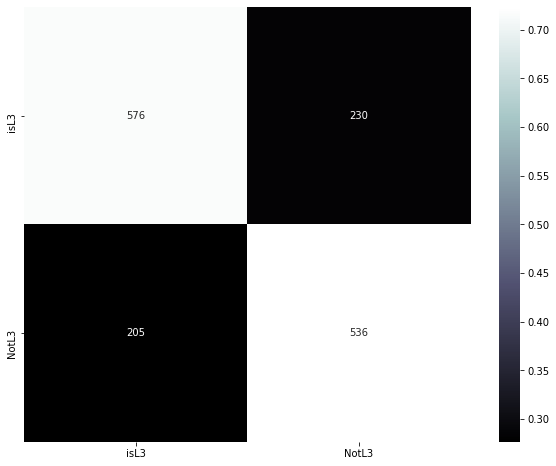

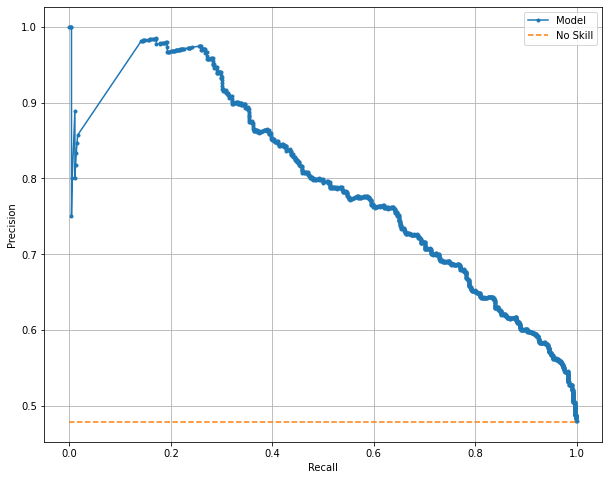

AttributeError: ignored

In [ ]:

from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C=50.0, class_weight='balanced', solver='newton-cg', random_state=28)
classes=['isL3','NotL3']
metrics_ML(clf, X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec,classes, gb=True)

In [ ]:
# from sklearn.svm import SVC
# clf=SVC(kernel='linear',probability=True).fit(X_train_word2vec, y_train_word2vec)
# classes=['isL3','NotL3']
# metrics_ML(clf, X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec,classes, gb=True)

In [ ]:
# RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=Balanced,
#                        criterion='gini', max_depth=8, max_features='auto',
#                        max_leaf_nodes=None, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=500,
#                        n_jobs=None, oob_score=False, random_state=1, verbose=0,
#                        warm_start=False)

Execution time : 33.037 s
Score : 77.31 %

Classification Report

              precision    recall  f1-score   support

        isL1       0.78      0.79      0.78       806
       NotL1       0.77      0.76      0.76       741

    accuracy                           0.77      1547
   macro avg       0.77      0.77      0.77      1547
weighted avg       0.77      0.77      0.77      1547


Confusion Matrix





Model: f1-score=0.762 AUC=0.875




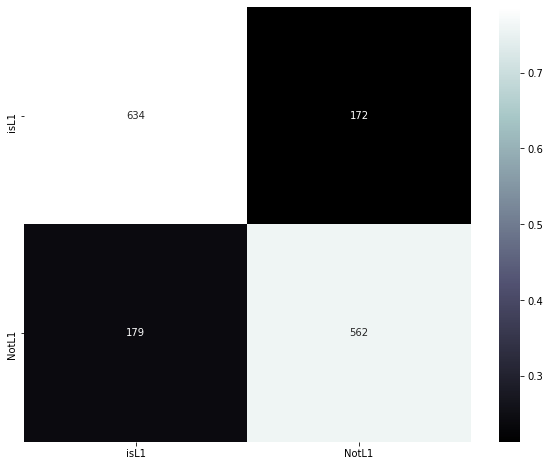

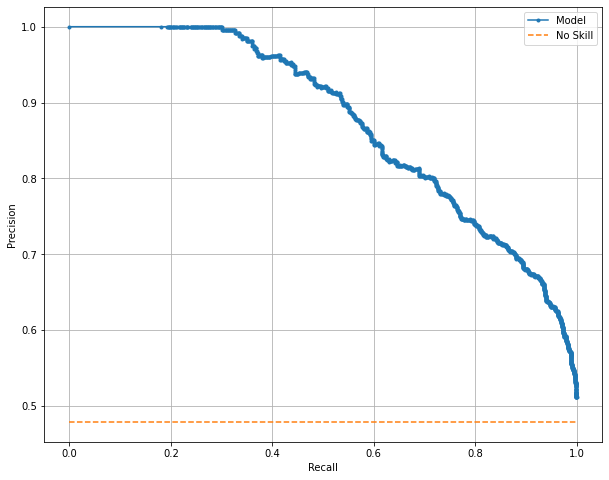

AttributeError: ignored

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfcl_b = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
classes=['isL1','NotL1']
metrics_ML(rfcl_b, X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec,classes, gb=True)

In [ ]:
from xgboost import XGBClassifier
cxgblf = XGBClassifier(max_depth=None, learning_rate=0.02,
                            n_estimators=500,
                            silent=False, objective='binary:logistic',
                            nthread=-1, gamma=0,
                            min_child_weight=4, max_delta_step=0, subsample=1,
                            colsample_bytree=0.6,
                            base_score=0.5,
                            seed=0, missing=None,verbosity=1,booster='gbtree')

In [ ]:
cxgblf.fit(X_train_word2vec, y_train_word2vec,eval_metric='error',early_stopping_rounds=50,eval_set=[(X_train_word2vec, y_train_word2vec), (X_test_word2vec, y_test_word2vec)])

[0]	validation_0-error:0.310196	validation_1-error:0.348416
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.269239	validation_1-error:0.2883
[2]	validation_0-error:0.269886	validation_1-error:0.2883
[3]	validation_0-error:0.26773	validation_1-error:0.279897
[4]	validation_0-error:0.265359	validation_1-error:0.281189
[5]	validation_0-error:0.261263	validation_1-error:0.281836
[6]	validation_0-error:0.262125	validation_1-error:0.285714
[7]	validation_0-error:0.261048	validation_1-error:0.276018
[8]	validation_0-error:0.258245	validation_1-error:0.276665
[9]	validation_0-error:0.256952	validation_1-error:0.275372
[10]	validation_0-error:0.254365	validation_1-error:0.2702
[11]	validation_0-error:0.250485	validation_1-error:0.275372
[12]	validation_0-error:0.251132	validation_1-error:0.277311
[13]	validation_0-error:0.249192	validation_1-error:0.274079
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.04, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=None, n_estimators=500, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=False, subsample=1, verbosity=1)

In [ ]:
best_iteration = cxgblf.get_booster().best_ntree_limit
best_iteration

127

In [ ]:
cxgblf.best_score

0.234648

In [ ]:
# {'n_estimators': 300, 'learning_rate' : 0.2,
#               'objective': 'binary:logistic', 'max_depth':3, 
#               'min_child_weight':4,'learning_rate':0.05,
#               'max_delta_step': 0, 'subsample': 1}

Execution time : 12.311 s
Score : 76.54 %

Classification Report

              precision    recall  f1-score   support

        isL1       0.79      0.76      0.77       806
       NotL1       0.75      0.77      0.76       741

    accuracy                           0.77      1547
   macro avg       0.77      0.77      0.77      1547
weighted avg       0.77      0.77      0.77      1547


Confusion Matrix





Model: f1-score=0.760 AUC=0.856




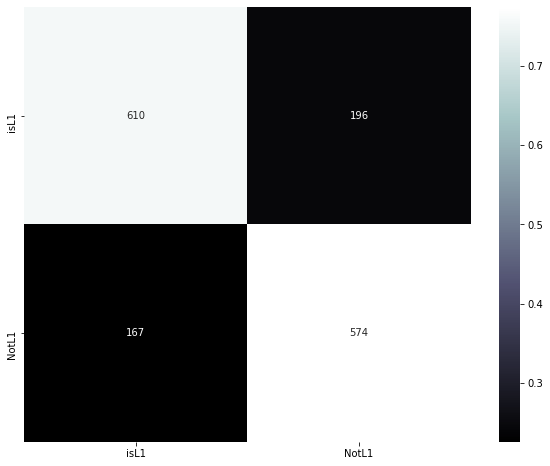

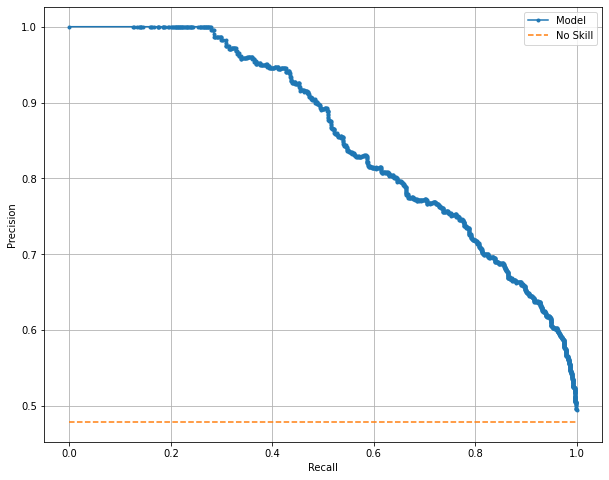

AttributeError: ignored

In [ ]:
classes=['isL1','NotL1']
metrics_ML(cxgblf, X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec,classes, gb=True)

In [ ]:
# cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
# fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
# csv = GridSearchCV(XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 3,verbose=3)

In [ ]:
# csv.fit(X_train_word2vec, y_train_word2vec)

In [ ]:
# csv.best_params_

In [ ]:
# cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
# fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight':4}

In [ ]:
# csv = GridSearchCV(XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 3,verbose=3) 
# csv.fit(X_train_word2vec, y_train_word2vec)

In [ ]:
# csv.best_params_

In [ ]:
# cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
# fix_params = {'n_estimators': 500, 'learning_rate' : 0.2,
#               'objective': 'binary:logistic', 'max_depth': 3, 
#               'min_child_weight':4,
#               'max_delta_step': 0, 'subsample': 1}

In [ ]:
# csv = GridSearchCV(XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 3,verbose=3) 
# csv.fit(X_train_word2vec, y_train_word2vec)

In [ ]:
# csv.best_params_

In [ ]:
# fix_params={'n_estimators': 300, 'learning_rate' : 0.2,
#               'objective': 'binary:logistic', 'max_depth':3, 
#               'min_child_weight':4,'learning_rate':0.05,
#               'max_delta_step': 0, 'subsample': 1}

In [ ]:
# final_param=fix_params
# print(final_param)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1200, num = 6)]
# # Number of features to consider at every split
# max_features = ['auto']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 30, num = 4)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)


{'n_estimators': [500, 640, 780, 920, 1060, 1200], 'max_features': ['auto'], 'max_depth': [5, 13, 21, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune

# rf = RandomForestClassifier(n_jobs=-1)
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=3, random_state=42,scoring='f1_weighted')
# # Fit the random search model
# rf_random.fit(X_train_word2vec, y_train_word2vec)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=780, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=780, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=False, score=0.507, total=  37.6s
[CV] n_estimators=780, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.6s remaining:    0.0s


[CV]  n_estimators=780, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=False, score=0.514, total=  37.0s
[CV] n_estimators=780, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  n_estimators=780, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=False, score=0.518, total=  36.8s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=True, score=0.502, total=  15.3s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=True, score=0.511, total=  15.3s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=True, score=0.512, total=  15.2s
[CV] n_estimators=920, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=21

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 21,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 780}

In [ ]:
# from sklearn.model_selection import GridSearchCV
# forest = RandomForestClassifier(random_state = 1, n_estimators = 10, min_samples_split = 1)
# n_estimators = [500,800,1200]
# #max_depth = [8,9,10]
# min_samples_split = [2,3]
# min_samples_leaf = [1,2] 
# max_features= ['auto']
# hyperF = dict(n_estimators = n_estimators, 
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf,
#               max_features=max_features)

# gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 3, 
#                       n_jobs = -1,scoring='f1_weighted')
# bestF = gridF.fit(X_train_word2vec, y_train_word2vec)
# print(bestF.best_estimator_)
# print(bestF.best_score_)

## Multi class classifier for L3

In [ ]:
# creating train dataframe for not L1
NotL1_tickets_df = train[train[202] == 1]
NotL1_tickets_df.shape

(3010, 204)

In [ ]:

# Determined if the dataset is balanced or imbalanced for multiclass classification
ratio = np.min(NotL1_tickets_df[203].value_counts()) / np.max(NotL1_tickets_df[203].value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")
    #from imblearn.over_sampling import ADASYN
    # put class for debalanced data 
    # in progress


The dataset is imbalanced (ratio=0.083)


In [ ]:
#creating X and Y for L1 classication
# X=train.drop(train.columns[[[-1, -2]], axis=1)
# X.shape
L3_X=NotL1_tickets_df[NotL1_tickets_df.columns[:201]]
L3_Y=NotL1_tickets_df[NotL1_tickets_df.columns[203]]

In [ ]:
L3_Y.unique

<bound method Series.unique of 428     12.0
574      5.0
1680    72.0
5178    23.0
455      4.0
        ... 
623     72.0
3321     6.0
6047    72.0
5352    23.0
601     45.0
Name: 203, Length: 3010, dtype: float64>

In [ ]:
L3_X_train_word2vec, L3_X_test_word2vec, L3_y_train_word2vec, L3_y_test_word2vec = train_test_split(L3_X, L3_Y, 
                                                                                        test_size=0.25, random_state=40)

In [ ]:
# from sklearn.linear_model import LogisticRegression
# clf=LogisticRegression(C=50.0, class_weight='balanced', solver='newton-cg', 
#                          multi_class='multinomial', n_jobs=-1, random_state=28)
# classes=NotL1_tickets_df['LabelEncodings'].unique().tolist()
# clf.fit(L3_X_train_word2vec, L3_y_train_word2vec)
# L3_y_predicted_word2vec = clf.predict(L3_X_test_word2vec)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted',zero_division=0,)             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted',zero_division=0)
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted',zero_division=0)
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [ ]:
# accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(L3_y_test_word2vec, L3_y_predicted_word2vec)
# print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
#                                                                        recall_word2vec, f1_word2vec))

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(L3_y_test_word2vec, L3_y_predicted_word2vec))

In [ ]:
#compare_L3_results = compare_L3_results.append({'Algorithm Name': 'Logistic Regression','Accuracy':accuracy_word2vec,'Precision':precision_word2vec,'Recall':precision_word2vec ,'F1 Score': f1_word2vec}, ignore_index=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
#classes=NotL1_tickets_df['LabelEncodings'].unique().tolist()
rfcl.fit(L3_X_train_word2vec, L3_y_train_word2vec,)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
# from sklearn.metrics import fbeta_score, make_scorer
# scorer= make_scorer(f1_score, average = 'weighted')
# scorer

In [ ]:
# from sklearn.model_selection import GridSearchCV
# forest = RandomForestClassifier(random_state = 1, n_estimators = 10, min_samples_split = 1)
# n_estimators = [500,600]
# #max_depth = [2,5,8]
# min_samples_split = [2,3]
# min_samples_leaf = [1,2] 
# max_features= ['auto']
# hyperF = dict(n_estimators = n_estimators,
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf,
#               max_features=max_features)

# gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 2, 
#                       n_jobs = -1,scoring=scorer)
# bestF = gridF.fit(L3_X_train_word2vec, L3_y_train_word2vec)
# print(bestF.best_estimator_)
# print(bestF.best_score_)

In [ ]:
L3_y_predicted_word2vec = rfcl.predict(L3_X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(L3_y_test_word2vec, L3_y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.376, precision = 0.384, recall = 0.376, f1 = 0.353


In [ ]:
# compare_L3_results = compare_L3_results.append({'Algorithm Name': 'Random Forest','Accuracy':accuracy_word2vec,'Precision':precision_word2vec,'Recall':precision_word2vec ,'F1 Score': f1_word2vec}, ignore_index=True)

In [ ]:
# compare_L3_results.sort_values(by='Accuracy', ascending=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(L3_y_test_word2vec, L3_y_predicted_word2vec))

              precision    recall  f1-score   support

         2.0       0.75      0.32      0.45        28
         4.0       0.26      0.60      0.36        45
         5.0       0.19      0.16      0.18        31
         6.0       0.14      0.03      0.05        35
         8.0       0.44      0.29      0.35        24
         9.0       0.75      0.75      0.75        12
        10.0       0.00      0.00      0.00        11
        11.0       0.19      0.18      0.18        50
        12.0       0.26      0.43      0.33        47
        17.0       0.47      0.76      0.58        58
        18.0       0.29      0.15      0.20        26
        19.0       0.00      0.00      0.00        17
        22.0       0.11      0.07      0.08        15
        23.0       0.24      0.22      0.23        45
        25.0       0.44      0.33      0.38        12
        27.0       0.27      0.20      0.23        20
        28.0       0.00      0.00      0.00        14
        34.0       0.38    

In [ ]:
#training both models  on entire train
rfcl_b.fit(L1_X,L1_Y)
cxgblf.fit(L1_X,L1_Y)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.04, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=None, n_estimators=500, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=False, subsample=1, verbosity=1)

In [ ]:
rfcl.fit(L3_X,L3_Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
final_X_test=test[test.columns[:201]]
final_Y_test=test[test.columns[203]]

In [ ]:
final_Y_test.shape

(1547,)

In [ ]:
#binary classfication predictions
intermediate_preds=rfcl_b.predict(final_X_test)
#intermediate_preds=cxgblf.predict(final_X_test, ntree_limit=best_iteration)
# intermediate_preds


In [ ]:
intermediate_preds

array([0., 1., 0., ..., 1., 1., 1.])

In [ ]:
import collections
elements_count = collections.Counter(intermediate_preds)
# printing the element and the frequency
for key, value in elements_count.items():
   print(f"{key}: {value}")

0.0: 834
1.0: 713


In [ ]:
#multiclass predictions
L3predictions=rfcl.predict(final_X_test)

In [ ]:
L3predictions

array([17., 12., 11., ..., 12., 12.,  4.])

In [ ]:
#combining two predictions list to make final prediction list
final_pred = []
for idx, val in enumerate(intermediate_preds):
    if intermediate_preds[idx]==0:
      final_pred.append(0)
    else:
      final_pred.append(L3predictions[idx])

In [ ]:
#final_pred = rfcl.predict(final_X_test)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(final_pred, final_Y_test)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.569, precision = 0.597, recall = 0.569, f1 = 0.576


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(final_pred, final_Y_test))

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       834
         2.0       0.29      1.00      0.44         8
         4.0       0.40      0.22      0.28        97
         5.0       0.21      0.18      0.19        33
         6.0       0.20      0.24      0.22        17
         8.0       0.14      0.17      0.15        18
         9.0       0.78      1.00      0.88        14
        10.0       0.12      0.33      0.18         9
        11.0       0.10      0.11      0.11        37
        12.0       0.39      0.23      0.29        94
        17.0       0.49      0.44      0.47        61
        18.0       0.15      0.17      0.16        23
        19.0       0.00      0.00      0.00         1
        22.0       0.15      0.25      0.19         8
        23.0       0.06      0.12      0.08        16
        25.0       0.14      0.50      0.22         4
        27.0       0.10      0.14      0.12        14
        28.0       0.00    